### Import Libraries

In [ ]:
import os
import h3
import glob
import contextily
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.ops import unary_union
from datetime import datetime, timedelta
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from scipy.stats import linregress, pearsonr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon, MultiPolygon, mapping, Point

### Load OD Flows and Trajectories

In [3]:
data_folder = '../data/' 

# Read the compressed CSV into a DataFrame
hex_OD_allactivity = pd.read_csv(os.path.join(data_folder, 'hex_OD_allactivity.csv.gz'),
                 compression='gzip') # Level 9

msoa_OD_allactivity = pd.read_csv(os.path.join(data_folder, 'msoa_OD_allactivity.csv.gz'),
                 compression='gzip')

msoa_OD_travel2work = pd.read_csv(os.path.join(data_folder, 'msoa_OD_travel2work.csv.gz'),
                 compression='gzip')

trajectory_GLA_sample5000 = pd.read_csv(os.path.join(data_folder, 'trajectory_GLA_sample5000.csv.gz'),
                 compression='gzip')

### Load Geometries

In [226]:
# London geometry
london_msoa_2021 = gpd.read_file('../data/msoa_england_2021.gpkg')
london_h3 = gpd.read_file('../data/london_h3.geojson')

In [227]:
### Load Socioeconomic Data
msoa_annual_income = pd.read_excel(os.path.join(data_folder, 'mso.xlsx'), 
                   sheet_name='Total annual income', header=4) # household disposable income

In [228]:
london_msoa_2021 = london_msoa_2021.merge(msoa_annual_income[['MSOA code', 'Total annual income (£)']].rename(columns={'MSOA code': 'MSOA21CD'}), 
                                          how='left', on='MSOA21CD')

# Remove msoa entries without income
london_msoa_2021 = london_msoa_2021.dropna()

### Exploratory Analysis

Spatio-temporal distribution of mobility pattern over London

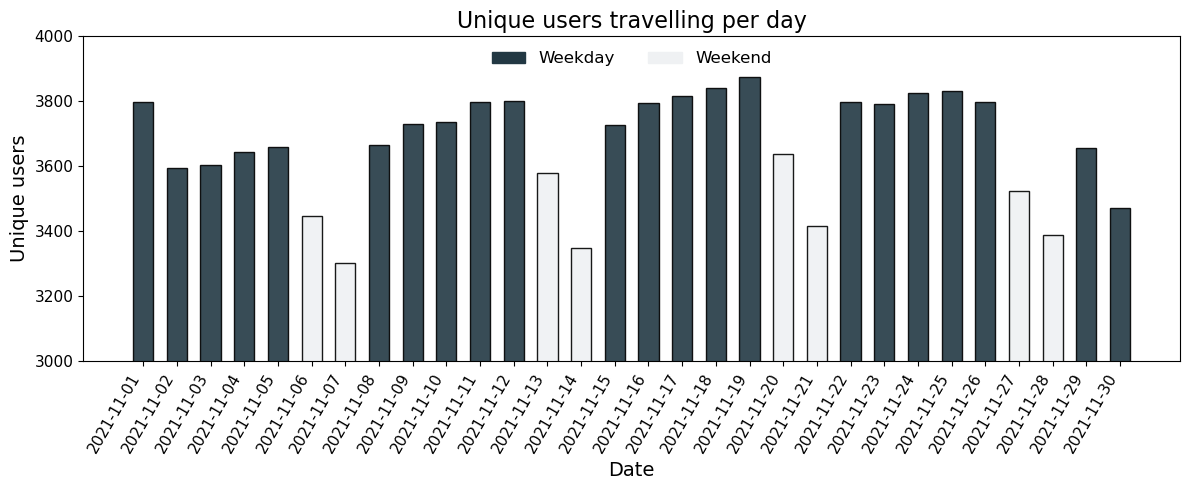

In [ ]:
# One bar per day: unique users travelling by day
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Ensure users_per_day exists; compute if not
if 'users_per_day' not in globals():
    _tmp = trajectory_GLA_sample5000.dropna(subset=['userid', 'start_time']).copy()
    if not pd.api.types.is_datetime64_any_dtype(_tmp['start_time']):
        _tmp['start_time'] = pd.to_datetime(_tmp['start_time'], errors='coerce')
    _tmp['date'] = _tmp['start_time'].dt.date
    users_per_day = (
        _tmp.groupby('date')['userid']
            .nunique()
            .rename('users_travelling')
            .reset_index()
            .sort_values('date')
    )

# Convert to datetime
users_per_day['date'] = pd.to_datetime(users_per_day['date'])

# Assign colors: weekends (#eff1f3), weekdays (#223843)
colors = users_per_day['date'].apply(
    lambda d: '#eff1f3' if d.weekday() >= 5 else '#223843'
)

labels = users_per_day['date'].dt.strftime('%Y-%m-%d')
values = users_per_day['users_travelling']

# Increase height
plt.figure(figsize=(12, 5))
# Use narrower width for thinner bars
plt.bar(labels, values, color=colors, edgecolor='black', alpha=0.9, width=0.6)

# Titles and labels with larger font sizes
plt.title('Unique users travelling per day', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Unique users', fontsize=14)

plt.xticks(rotation=60, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(3000, 4000)

# Add legend inside the plot (top-right corner)
weekday_patch = mpatches.Patch(color='#223843', label='Weekday')
weekend_patch = mpatches.Patch(color='#eff1f3', label='Weekend')
plt.legend(
    handles=[weekday_patch, weekend_patch],
    ncol=2, 
    loc='upper center',
    frameon=False,
    fontsize=12
)

plt.tight_layout()
plt.show()


### Spatiotemporal distribution (Weekday)

In [176]:
# Filter by most active weekday
chosen_day = '2021-11-19'
chosen_day = datetime.strptime(chosen_day, "%Y-%m-%d").date()

weekday_traces = trajectory_GLA_sample5000.copy()
weekday_traces['date'] = pd.to_datetime(weekday_traces['start_time']).dt.date
weekday_traces = weekday_traces[weekday_traces['date'] == chosen_day]

In [177]:
# Merge MSOA locations to traces
activity_locations = london_msoa_2021[['MSOA21CD','geometry']].rename(columns={'MSOA21CD':'loc_msoa'}).copy()
activity_locations['geometry'] = activity_locations['geometry'].centroid
weekday_traces = weekday_traces.merge(activity_locations, how='left', on='loc_msoa')
weekday_traces = gpd.GeoDataFrame(weekday_traces, crs=london_msoa_2021.crs)

In [178]:
def interpolate_time_gaps(
    gdf: gpd.GeoDataFrame,
    user_col: str = "userid",
    start_col: str = "start_time",
    end_col: str = "end_time",
    activity_col: str = "activity",
    interval_minutes: int = 15,
) -> gpd.GeoDataFrame:
    """
    Insert rows at fixed time intervals between previous end_time and next start_time
    per user. Geometry is linearly interpolated between the two locations.

    New rows:
      - start_time = end_time = intermediate timestamp
      - activity = previous row's activity value
      - duration = 0.0
      - loc_msoa = NaN
      - date = YYYY-MM-DD string
    """
    required = {user_col, start_col, end_col, activity_col}
    if not required.issubset(gdf.columns):
        missing = required - set(gdf.columns)
        raise ValueError(f"Missing required column(s): {missing}")

    gdf = gdf.copy()
    gdf[start_col] = pd.to_datetime(gdf[start_col], errors="coerce")
    gdf[end_col]   = pd.to_datetime(gdf[end_col], errors="coerce")

    gdf = gdf.sort_values([user_col, start_col, end_col]).reset_index(drop=True)

    crs = gdf.crs
    step = timedelta(minutes=interval_minutes)
    new_rows = []

    for uid, sub in gdf.groupby(user_col, sort=False):
        sub = sub.sort_values([start_col, end_col]).reset_index(drop=True)
        for i in range(1, len(sub)):
            prev_row = sub.loc[i - 1]
            next_row = sub.loc[i]

            prev_end = prev_row[end_col]
            next_start = next_row[start_col]

            if pd.isna(prev_end) or pd.isna(next_start):
                continue
            if next_start - prev_end <= step:
                continue

            p0 = prev_row.geometry
            p1 = next_row.geometry
            if not isinstance(p0, Point) or not isinstance(p1, Point):
                continue

            total_seconds = (next_start - prev_end).total_seconds()
            t = prev_end + step

            while t < next_start:
                alpha = (t - prev_end).total_seconds() / total_seconds if total_seconds > 0 else 0.0
                x = (1 - alpha) * p0.x + alpha * p1.x
                y = (1 - alpha) * p0.y + alpha * p1.y

                new_rows.append({
                    user_col: uid,
                    start_col: t,
                    end_col: t,
                    "duration": 0.0,
                    "loc_msoa": np.nan,
                    activity_col: prev_row[activity_col],  # use previous activity
                    "date": t.date(),  # will format to string before saving
                    "geometry": Point(x, y),
                })
                t += step

    gdf_new = gpd.GeoDataFrame(new_rows, geometry="geometry", crs=crs)

    gdf_out = pd.concat([gdf, gdf_new], ignore_index=True)
    gdf_out = gdf_out.sort_values([user_col, start_col, end_col]).reset_index(drop=True)

    if "date" in gdf_out.columns:
        gdf_out["date"] = pd.to_datetime(gdf_out["date"], errors="coerce").dt.strftime("%Y-%m-%d")

    return gdf_out

In [179]:
interpolated_traces = interpolate_time_gaps(weekday_traces)

/var/folders/sl/b1w4bg0n63l4xh0kblz9m3br0000gn/T/ipykernel_87837/3514025906.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(activities) if len(activities) else 1)
/var/folders/sl/b1w4bg0n63l4xh0kblz9m3br0000gn/T/ipykernel_87837/3514025906.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfp['is_stationary'] = dfp['is_stationary'].fillna(False).astype(bool)
/var/folders/sl/b1w4bg0n63l4xh0kblz9m3br0000gn/T/ipykernel_87837/3514025906.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a futu

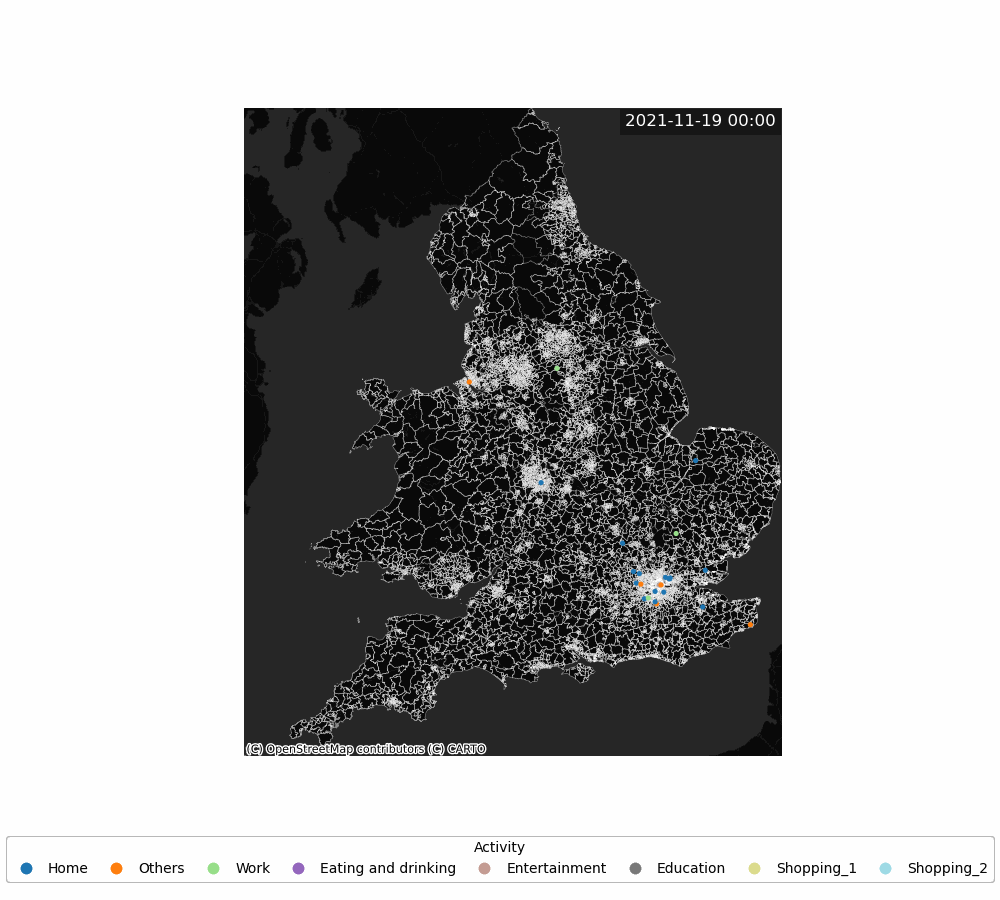

In [180]:
# Animated GIF using interpolated positions each timestep (15‑min cadence)
# - Fading trails from recent segments
# - Current-frame points with jitter for stationary users
# - Dark CartoDB basemap (no labels) + MSOA boundaries (alpha=0.5)

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.collections import LineCollection
import contextily as ctx
from IPython.display import Image, display

# Preconditions
gdf = interpolated_traces.copy()
if 'activity' not in gdf.columns:
    gdf['activity'] = 'unknown'

# Ensure datetime and geometry
gdf = gdf.dropna(subset=['geometry', 'userid', 'start_time']).copy()
gdf['start_time'] = pd.to_datetime(gdf['start_time'], errors='coerce')
gdf = gdf.dropna(subset=['start_time'])

# Early exit if nothing to animate
if gdf.empty:
    display("No data available to animate.")
else:
    # CRS handling
    src_crs = gdf.crs or (london_msoa_2021.crs if hasattr(london_msoa_2021, 'crs') else 'EPSG:4326')
    if gdf.crs is None:
        gdf = gpd.GeoDataFrame(gdf, geometry='geometry', crs=src_crs)

    msoa_3857 = london_msoa_2021.to_crs(epsg=3857)
    gdf_3857 = gdf.to_crs(epsg=3857).sort_values(['userid', 'start_time']).reset_index(drop=True)

    # Coordinates
    gdf_3857['x'] = gdf_3857.geometry.x
    gdf_3857['y'] = gdf_3857.geometry.y

    # Build adjacent pairs per user (prev -> current) to represent movement in each 15-min step
    prev = gdf_3857.groupby('userid')[['start_time', 'x', 'y', 'activity']].shift(1)
    pairs = gdf_3857.copy()
    pairs['t0'] = prev['start_time']
    pairs['x0'] = prev['x']
    pairs['y0'] = prev['y']
    pairs['activity0'] = prev['activity']
    pairs = pairs.dropna(subset=['t0'])  # only rows with a previous point
    pairs.rename(columns={'start_time': 't1', 'x': 'x1', 'y': 'y1', 'activity': 'activity1'}, inplace=True)

    # Stationary detection
    pairs['dist'] = np.hypot(pairs['x1'] - pairs['x0'], pairs['y1'] - pairs['y0'])
    stationary_thresh_m = 30.0
    pairs['is_stationary'] = (pairs['dist'] < stationary_thresh_m).astype(bool)

    # Frames timeline (15-min)
    start = gdf_3857['start_time'].min().floor('15min')
    end = gdf_3857['start_time'].max().ceil('15min')
    if pd.isna(start) or pd.isna(end):
        display("No valid timestamps to animate.")
    else:
        frames = pd.date_range(start=start, end=end, freq='15min')
        if len(frames) < 2:
            frames = pd.date_range(start=start, periods=2, freq='15min')

        # Map times to frame idx for pairs (use t1, the current point time)
        if not pairs.empty:
            pairs['frame_idx'] = np.searchsorted(frames.values, pairs['t1'].values, side='right') - 1
            pairs['frame_idx'] = pairs['frame_idx'].clip(0, len(frames)-1)
        else:
            pairs['frame_idx'] = []

        # Also index the point records per frame for current positions
        points = gdf_3857.copy()
        points['frame_idx'] = np.searchsorted(frames.values, points['start_time'].values, side='right') - 1
        points['frame_idx'] = points['frame_idx'].clip(0, len(frames)-1)

        pairs_by_frame = {i: df for i, df in pairs.groupby('frame_idx')} if not pairs.empty else {}
        points_by_frame = {i: df for i, df in points.groupby('frame_idx')} if not points.empty else {}

        # Colors per activity
        activities = pd.Index(points['activity'].fillna('unknown').unique()) if not points.empty else pd.Index(['unknown'])
        try:
            from matplotlib import colormaps as mpl_cmaps
            cmap = mpl_cmaps.get_cmap('tab20', len(activities) if len(activities) else 1)
        except Exception:
            cmap = plt.cm.get_cmap('tab20', len(activities) if len(activities) else 1)
        color_map = {a: cmap(i) for i, a in enumerate(activities)}

        # Figure and basemap
        fig, ax = plt.subplots(figsize=(10, 9))
        # xmin, ymin, xmax, ymax = interpolated_traces.to_crs('epsg:3857').total_bounds
        xmin, ymin, xmax, ymax = msoa_3857.total_bounds

        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        try:
            ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatterNoLabels, crs='EPSG:3857')
        except Exception as e:
            # Tile load failed (e.g., offline). Proceed without basemap.
            print(f"Basemap unavailable: {e}")
        msoa_3857.boundary.plot(ax=ax, color='white', linewidth=0.4, alpha=0.5, zorder=2)

        lc = LineCollection([], linewidths=1.6, zorder=3)
        ax.add_collection(lc)
        scat = ax.scatter([], [], s=14, zorder=4)

        time_text = ax.text(0.99, 0.99, '', transform=ax.transAxes, ha='right', va='top', fontsize=12,
                            color='white', bbox=dict(facecolor='black', alpha=0.35, edgecolor='none'))

        from matplotlib.lines import Line2D
        legend_handles = [
            Line2D([0], [0],
                marker='o', color='w', label=str(a),
                markerfacecolor=color_map.get(a, (0.8, 0.8, 0.8, 1)),
                markersize=8, linestyle='None')
            for a in activities
        ]

        if legend_handles:
            # Add some bottom margin so the legend is not clipped in the saved GIF
            fig.subplots_adjust(bottom=0.16)

            # Put legend at the bottom center of the figure, outside the axes
            legend = fig.legend(
                handles=legend_handles,
                loc='lower center',
                bbox_to_anchor=(0.5, 0.02),
                ncol=min(len(activities), 8),     # horizontal layout; wraps to extra rows if needed
                title='Activity',
                frameon=True,
                borderaxespad=0.0,
                handletextpad=0.6,
                columnspacing=1.0,
                markerscale=1.2
            )
            # Style the legend box
            legend.get_frame().set_facecolor('white')
            legend.get_frame().set_alpha(0.9)
            legend.get_frame().set_edgecolor('0.7')


        ax.set_axis_off()

        # Trail fading parameters
        fade_frames = 6  # how many recent frames to keep visible
        rng = np.random.default_rng(42)

        # Helpers
        def with_alpha(base_rgba, a):
            r, g, b, _ = base_rgba if len(base_rgba) == 4 else (*base_rgba[:3], 1.0)
            return (r, g, b, float(a))

        def update(i):
            # Lines: include segments from recent frames [i - fade_frames + 1, i]
            f0 = max(0, i - fade_frames + 1)
            segs_all = []
            seg_cols = []

            for f in range(f0, i + 1):
                df = pairs_by_frame.get(f)
                if df is None or len(df) == 0:
                    continue
                age = i - f
                alpha = max(0.0, 1.0 - (age / fade_frames))
                # Build segments from (x0,y0) -> (x1,y1); color by activity1
                start_xy = np.column_stack([df['x0'].values, df['y0'].values])
                end_xy   = np.column_stack([df['x1'].values, df['y1'].values])
                segs = np.stack([start_xy, end_xy], axis=1)  # (N,2,2)
                segs_all.append(segs)
                seg_cols.extend([with_alpha(color_map.get(act, (0.8,0.8,0.8,1)), alpha) for act in df['activity1'].values])

            if segs_all:
                seg_array = np.concatenate(segs_all, axis=0)
                lc.set_segments(seg_array)
                lc.set_color(seg_cols)
            else:
                lc.set_segments([])
                lc.set_color([])

            # Points: use current frame points; jitter stationary ones to show density
            dfp = points_by_frame.get(i)
            pts = []
            cols = []
            if dfp is not None and len(dfp):
                # Merge in stationary flag from pairs for those with a previous point ending at this frame
                stat_map = pairs_by_frame.get(i)
                if stat_map is not None and len(stat_map):
                    stat_info = stat_map[['userid', 'is_stationary']]
                    # Some users may have multiple rows; keep last
                    stat_info = stat_info.groupby('userid', as_index=False)['is_stationary'].last()
                    dfp = dfp.merge(stat_info, how='left', on='userid')
                else:
                    dfp = dfp.copy()
                    dfp['is_stationary'] = False

                # Ensure boolean dtype for mask
                dfp['is_stationary'] = dfp['is_stationary'].fillna(False).astype(bool)

                moving = dfp[~dfp['is_stationary']]
                if len(moving):
                    pts.append(np.column_stack([moving['x'].values, moving['y'].values]))
                    cols.extend([with_alpha(color_map.get(a, (0.8,0.8,0.8,1)), 1.0) for a in moving['activity'].values])

                stationary = dfp[dfp['is_stationary']]
                if len(stationary):
                    base_xy = np.column_stack([stationary['x'].values, stationary['y'].values])
                    n_jitter = 3
                    jitter_scale = 20.0  # meters
                    jitter = rng.normal(scale=jitter_scale, size=(len(base_xy), n_jitter, 2))
                    jittered = (base_xy[:, None, :] + jitter).reshape(-1, 2)
                    pts.append(jittered)
                    cols.extend([with_alpha(color_map.get(a, (0.8,0.8,0.8,1)), 0.85) for a in stationary['activity'].repeat(n_jitter).values])

            if pts:
                pts_all = np.vstack(pts)
                scat.set_offsets(pts_all)
                scat.set_facecolors(cols)
                scat.set_edgecolors('none')
            else:
                scat.set_offsets(np.empty((0, 2)))
                scat.set_facecolors([])

            time_text.set_text(pd.to_datetime(frames[i]).strftime('%Y-%m-%d %H:%M'))
            return lc, scat, time_text

        anim = FuncAnimation(fig, update, frames=len(frames), interval=250, blit=False)

        # Save GIF
        out_path = '../figures/movement_interpolated_trails_weekday.gif'
        try:
            writer = PillowWriter(fps=4)
            anim.save(out_path, writer=writer)
            plt.close(fig)
            display(Image(filename=out_path))
        except Exception as e:
            plt.close(fig)
            raise

### Distance and Income Relationship

In [ ]:
london_msoa_2021_centroid = london_msoa_2021.copy()
london_msoa_2021_centroid['geometry'] = london_msoa_2021_centroid['geometry'].centroid

In [237]:
msoa_OD_travel2work = msoa_OD_travel2work.merge(london_msoa_2021_centroid[['MSOA21CD', 'Total annual income (£)', 'geometry']].rename(columns={'MSOA21CD': 'MSOA21CD_home', 'geometry': 'home_geometry'}), on='MSOA21CD_home', how='left')
msoa_OD_travel2work = msoa_OD_travel2work.merge(london_msoa_2021_centroid[['MSOA21CD', 'geometry']].rename(columns={'MSOA21CD': 'MSOA21CD_work', 'geometry': 'work_geometry'}), on='MSOA21CD_work', how='left')

In [ ]:
msoa_OD_travel2work = msoa_OD_travel2work.dropna()

In [ ]:
# Compute Euclidean Distance with Numpy
x1 = msoa_OD_travel2work["home_geometry"].apply(lambda p: p.x)
y1 = msoa_OD_travel2work["home_geometry"].apply(lambda p: p.y)
x2 = msoa_OD_travel2work["work_geometry"].apply(lambda p: p.x)
y2 = msoa_OD_travel2work["work_geometry"].apply(lambda p: p.y)

msoa_OD_travel2work["dist_m"] = np.hypot(x1 - x2, y1 - y2)
msoa_OD_travel2work['total_travel_distance'] = msoa_OD_travel2work['count'] * msoa_OD_travel2work['dist_m']

/var/folders/sl/b1w4bg0n63l4xh0kblz9m3br0000gn/T/ipykernel_87837/1822312109.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msoa_OD_travel2work["dist_m"] = np.hypot(x1 - x2, y1 - y2)


In [ ]:
# Compute average travel distance 
aggregated_work = msoa_OD_travel2work.groupby("MSOA21CD_home", as_index=False)[["count", "total_travel_distance"]].sum()
aggregated_work['average_travel_distance'] = aggregated_work['total_travel_distance'] / aggregated_work['count']
aggregated_work = aggregated_work.merge(london_msoa_2021_centroid[['MSOA21CD', 'Total annual income (£)']].rename(columns={'MSOA21CD': 'MSOA21CD_home', 'geometry': 'home_geometry'}), on='MSOA21CD_home', how='left')

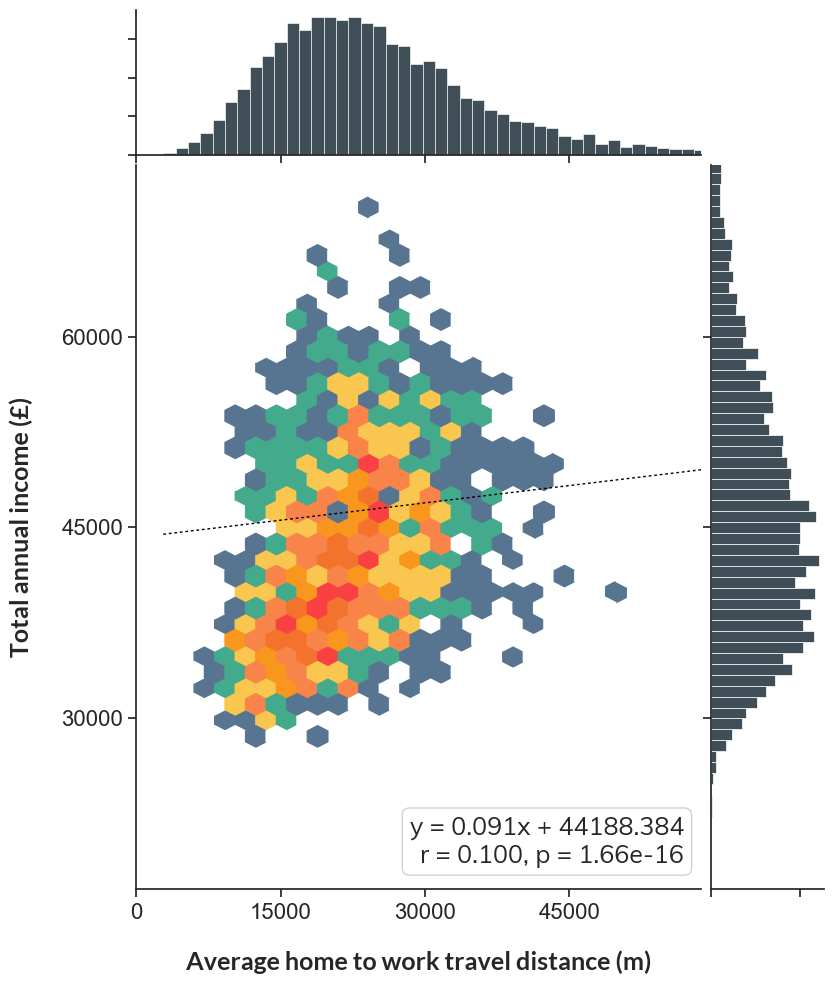

In [ ]:
# Data columns
x = aggregated_work['average_travel_distance']
y = aggregated_work['Total annual income (£)']

# Basic cleanup
mask = np.isfinite(x) & np.isfinite(y)
x = x[mask]
y = y[mask]

# Fonts and style
csfont = {'fontname': 'Muli'}
hfont  = {'fontname': 'Lato'}
mpl.rc('font', family='Muli')

my_color = ["#FFFFFF", '#577590', '#43aa8b', '#f9c74f', '#f9844a', '#f8961e', '#f3722c', '#f94144']
my_cmap = ListedColormap(sns.color_palette(my_color).as_hex())

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# Figure and axes with marginals
fig, ax = plt.subplots(figsize=(8.5, 10))
divider = make_axes_locatable(ax)
ax_marg_x = divider.append_axes("top",  size="20%", pad=0.1, sharex=ax)
ax_marg_y = divider.append_axes("right", size="20%", pad=0.1, sharey=ax)

# Main hexbin (use mincnt to suppress very sparse bins)
hb = ax.hexbin(
    x, y,
    gridsize=60,
    cmap=my_cmap,
    mincnt=3
)

# Regression and correlation
slope, intercept, r_value, p_value, std_err = linregress(x, y)
xr = np.array([x.min(), x.max()])
yr = intercept + slope * xr
ax.plot(xr, yr, color='black', linewidth=1, linestyle='--', dashes=[2, 2])

r, p = pearsonr(x, y)

# Annotation
ax.text(
    0.97, 0.03,
    f"y = {slope:.3f}x + {intercept:.3f}\n"
    f"r = {r:.3f}, p = {p:.2e}",
    transform=ax.transAxes,
    ha='right', va='bottom',
    fontsize=18, **csfont,
    bbox=dict(facecolor='white', alpha=0.9, edgecolor='0.8', boxstyle='round,pad=0.3')
)

# Marginal histograms
sns.histplot(x=x, ax=ax_marg_x, bins=100, color="#00141f")
sns.histplot(y=y, ax=ax_marg_y, bins=100, color="#00141f")

# Clean up marginal axes
for axm in (ax_marg_x, ax_marg_y):
    axm.set_xlabel("")
    axm.set_ylabel("")
    axm.spines["top"].set_visible(False)
    axm.spines["right"].set_visible(False)

plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_x.get_yticklabels(), visible=False)
plt.setp(ax_marg_y.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Axis labels
ax.set_xlabel('Average home to work travel distance (m)', fontsize=18, weight='bold', labelpad=20, **hfont)
ax.set_ylabel('Total annual income (£)', fontsize=18, weight='bold', labelpad=20, **hfont)

# Modest percentile zoom to focus the view while keeping extremes
x01, x99 = np.percentile(x, [1, 99])
y01, y99 = np.percentile(y, [1, 99])
xmed = np.median(x); xhalf = max(xmed - x01, x99 - xmed)
ymed = np.median(y); yhalf = max(ymed - y01, y99 - ymed)
ax.set_xlim(0, xmed + 0.8*xhalf)
ax.set_ylim(ymed - 0.8*yhalf, ymed + 0.8*yhalf)

# Ticks and layout
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.yaxis.set_major_locator(MaxNLocator(4))
ax.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.show()


### Social Mixing Potential

How do social activities (excluding home) in different areas influence a person below median income chances of interacting with people above the median income. 


In [ ]:
traj_income = trajectory_GLA_sample5000.copy()
median = london_msoa_2021['Total annual income (£)'].median()
print(f'Median msoa annual income (£): {median} ')


Median msoa annual income (£): 44900.0 


In [ ]:
user_homes = traj_income[traj_income['activity'] == 'Home']

# Keep only one row per unique user (by userid)
# If start_time exists, keep the earliest record per user; else keep first by order
if 'start_time' in user_homes.columns:
    user_homes = (
        user_homes
        .sort_values(['userid', 'start_time'])
        .drop_duplicates(subset=['userid'], keep='first')
        .reset_index(drop=True)
    )
else:
    user_homes = (
        user_homes
        .sort_values(['userid'])
        .drop_duplicates(subset=['userid'], keep='first')
        .reset_index(drop=True)
    )

# Quick confirmation
print(
    f"Rows after de-dup: {len(user_homes)} | "
    f"Unique users: {user_homes['userid'].nunique()}"
)
user_homes.head(5)

Rows after de-dup: 4889 | Unique users: 4889


userid          start_time            end_time  \
0  0000CE017254706FE06FE4166DC3CE00 2021-11-01 00:30:00 2021-11-01 12:30:00   
1  001B6A09FA76E6D649715B63BF477A83 2021-11-01 00:15:00 2021-11-01 07:00:00   
2  0058F712E3BE90D936AC62C40895AC07 2021-11-01 00:15:00 2021-11-01 07:00:00   
3  006E1B52EF1148E621613B402A03597C 2021-11-01 01:30:00 2021-11-01 08:30:00   
4  007ADEFC82993FEB2B53B5D9A0959319 2021-11-26 00:15:00 2021-11-26 14:00:00   

     duration   loc_msoa activity  
0  725.550000  E02006542     Home  
1  409.433333  E02002208     Home  
2  393.766667  E02000510     Home  
3  420.466667  E02000500     Home  
4  828.850000  E02000408     Home

In [ ]:
# Merge MSOA total annual income to userid
user_homes_income = user_homes.merge(london_msoa_2021[['MSOA21CD', 'Total annual income (£)']].rename(columns={'MSOA21CD': 'loc_msoa'}),
    on='loc_msoa'
)

# Create a mapping of user IDs to their total annual income
user_income_mapping = {user: income for user, income in zip(user_homes_income['userid'], user_homes_income['Total annual income (£)'])}

In [439]:
# Modify new end time based on duration of activity
traj_income['duration'] = traj_income['duration'].apply(lambda x: int(x))
# convert duration (minutes) to timedelta and add to start_time
traj_income['end_time'] = traj_income['start_time'] + pd.to_timedelta(traj_income['duration'], unit='m')


In [442]:
# Only retain activities that are not Home (assume no interaction when either user is home)
traj_income_social = traj_income[traj_income['activity']!='Home']

In [461]:
import pandas as pd

def interval_overlap(a_start, a_end, b_start, b_end):
    """Return overlap in minutes between two time intervals."""
    latest_start = max(a_start, b_start)
    earliest_end = min(a_end, b_end)
    delta = (earliest_end - latest_start).total_seconds() / 60.0
    return max(0, delta)

def total_overlap(df, target_user, user_income_mapping):
    """Return total overlap minutes and validation details for target_user."""
    # Ensure datetimes
    
    target_rows = df[df['userid'] == target_user]
    other_rows  = df[df['userid'] != target_user]
    
    total_minutes_lower = 0.0
    total_minutes_upper = 0.0

    # detailed_overlaps = []
    
    # Compare every target interval with every other user's interval
    for _, trow in target_rows.iterrows():
        for _, orow in other_rows.iterrows():
            overlap = interval_overlap(
                trow['start_time'], trow['end_time'],
                orow['start_time'], orow['end_time']
            )

            if overlap > 0 and user_income_mapping[orow['userid']] < 44900:
                total_minutes_lower += overlap

            elif overlap > 0 and user_income_mapping[orow['userid']] >= 44900:
                total_minutes_upper += overlap

                # detailed_overlaps.append({
                #     "target_start": trow['start_time'],
                #     "target_end": trow['end_time'],
                #     "other_user": orow['userid'],
                #     "other_start": orow['start_time'],
                #     "other_end": orow['end_time'],
                #     "overlap_minutes": overlap
                # })
    
    # details_df = pd.DataFrame(detailed_overlaps)
    # return total_minutes, details_df
    total_time = total_minutes_upper+total_minutes_lower
    try:
        prop = round(total_minutes_upper / total_time * 100, 2)
    except ZeroDivisionError:
        prop = 0
        
    return prop


In [462]:
# Create empty dict for each MSOA
MSOA_dict = {}
for msoa in traj_income['loc_msoa'].unique():
    MSOA_dict[msoa] = []

In [463]:
# Loop through and get the interaction for each user
for msoa in traj_income_social['loc_msoa'].unique():
    temp = traj_income_social[traj_income_social['loc_msoa'] == msoa]
    
    for user in temp['userid'].unique():
        # If user home income less than median, compute proportion
        try:
            if user_income_mapping[user] < median:
                total_prop = total_overlap(temp, user, user_income_mapping)
                MSOA_dict[msoa].append(total_prop)
        except KeyError:
            continue

In [466]:
MSOA_dict_copy = MSOA_dict.copy()

### Co-presence time by user split by other users' income (median = 44,900)
This computes, for each user, the total time spent co-present with other users, split into two groups based on whether the other user's income is strictly greater than 44,900. Uses the proximity pairs per frame already computed in `pairs_by_frame`. If income for a partner is missing, that interaction is skipped.

In [468]:
msoa_exposure = {k:np.mean(v) for k,v in MSOA_dict_copy.items()}

/Users/winston/miniconda3/envs/urban_mobility/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/winston/miniconda3/envs/urban_mobility/lib/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Proportion of time spent with higher SES individuals

In [475]:
msoa_exposure_df = pd.DataFrame([msoa_exposure]).T.reset_index()

In [480]:
msoa_exposure_df.columns = ['MSOA21CD', 'Social Exposure Index']

In [481]:
london_msoa_2021_sei = london_msoa_2021.copy()
london_msoa_2021_sei = london_msoa_2021_sei.merge(msoa_exposure_df, on='MSOA21CD', how='left')

In [495]:
london_msoa_2021_sei

MSOA21CD                  MSOA21NM            MSOA21NMW   BNG_E  \
0     E02000001        City of London 001                       532384   
1     E02000002  Barking and Dagenham 001                       548267   
2     E02000003  Barking and Dagenham 002                       548259   
3     E02000004  Barking and Dagenham 003                       551004   
4     E02000005  Barking and Dagenham 004                       548733   
...         ...                       ...                  ...     ...   
7075  W02000418       Carmarthenshire 027  Sir Gaerfyrddin 027  222870   
7076  W02000419          Denbighshire 017     Sir Ddinbych 017  302419   
7077  W02000421            Ceredigion 011       Ceredigion 011  271408   
7078  W02000422               Cardiff 048         Caerdydd 048  319643   
7079  W02000423               Cardiff 049         Caerdydd 049  318619   

       BNG_N        LAT      LONG                                GlobalID  \
0     181355  51.515621 -0.093490  {71249043-B176-4306-BA6C-D1A993B1B741}   
1     189685  51.586521  0.138756  {997A80A8-0EBE-461C-91EB-3E4122571A6E}   
2     188520  51.576061  0.138149  {62DED9D9-F53A-454D-AF35-04404D9DBE9B}   
3     186412  51.556389  0.176828  {511181CD-E71F-4C63-81EE-E8E76744A627}   
4     186824  51.560692  0.144267  {B0C823EB-69E0-4AE7-9E1C-37715CF3FE87}   
...      ...        ...       ...                                     ...   
7075  218344  51.835548 -4.572320  {85D6EF11-776F-4491-AE77-31E8BE14B7A4}   
7076  380863  53.315689 -3.466210  {C1BD1A81-6CCD-40E6-8679-86823DF26B20}   
7077  266662  52.283020 -3.886510  {E0FEBBBD-CFC4-4F1F-B238-3AB43D9FC257}   
7078  174132  51.460442 -3.158050  {2C33051D-BB6F-4723-8F04-EA9FD162335D}   
7079  174985  51.467960 -3.172980  {A67BC77D-FD05-4B03-BBFB-6206EF7FD684}   

                                               geometry  \
0     MULTIPOLYGON (((532135.138 182198.131, 532071....   
1     MULTIPOLYGON (((548881.563 190845.265, 548845....   
2     MULTIPOLYGON (((549102.438 189324.625, 549120....   
3     MULTIPOLYGON (((551550.056 187364.705, 551551....   
4     MULTIPOLYGON (((549099.634 187656.076, 549057....   
...                                                 ...   
7075  MULTIPOLYGON (((222186.703 229085.109, 221980....   
7076  MULTIPOLYGON (((302972.663 381406.09, 302966.1...   
7077  MULTIPOLYGON (((281652.906 291392.187, 281620....   
7078  MULTIPOLYGON (((319551.478 175706.424, 319378....   
7079  MULTIPOLYGON (((319431.187 175962.297, 319482....   

      Total annual income (£)  Social Exposure Index  
0                    101800.0              87.073404  
1                     43600.0              27.596667  
2                     50900.0              40.000000  
3                     52000.0              11.392000  
4                     48100.0              23.057692  
...                       ...                    ...  
7075                  40500.0               0.000000  
7076                  37700.0               0.000000  
7077                  41700.0                    NaN  
7078                  43900.0              22.222222  
7079                  40400.0               0.000000  

[7080 rows x 11 columns]

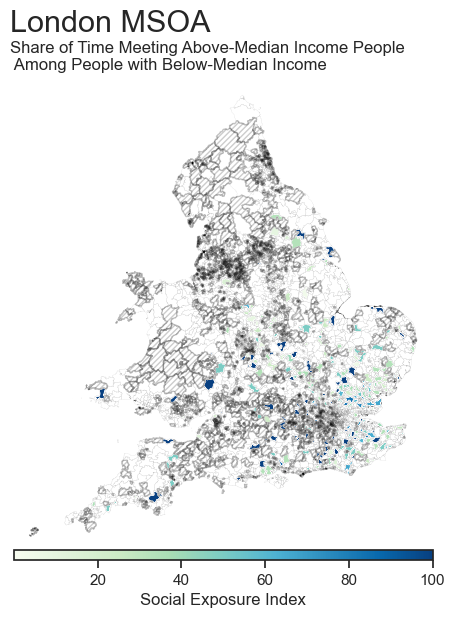

In [535]:
import matplotlib.pyplot as plt

# Instantiate a figure
fig, ax = plt.subplots(figsize=(18, 9))

# Customise plot with colorscale, 
london_msoa_2021_sei.plot(column='Social Exposure Index', ax=ax, cmap='GnBu', legend=True,
               legend_kwds={'label': "Social Exposure Index",
                             'orientation': "horizontal",
                             'shrink': 0.30,
                             'anchor':(0.5, 2.2), 
                             'aspect':40, 
                             'ticks':None},
               missing_kwds={"color": "white",
                              "edgecolor": "black",
                              "hatch": "//////",
                              "alpha":0.2,
                              "label": "Missing values",
                              }
                )
london_msoa_2021.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.05, alpha=0.5)

# Turn off x-axis
ax.set_axis_off()

# Add title and subtitles
ax.set_title('Share of Time Meeting Above-Median Income People \n Among People with Below-Median Income ', fontsize=12, loc='left', pad=0)
fig.suptitle('London MSOA ', fontsize=22, x=0.394, y = 0.95, horizontalalignment='left')

# plt.savefig('../figures/social_share.png', dpi=300)
plt.show()